In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [2]:
import IPython
from IPython.display import display

import io
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import PIL
import cv2

import sneks
import gym

import torch
import torch.nn as nn

DEVICE = 'cpu'

torch.__version__, torch.cuda.is_available()

('1.3.1', True)

In [286]:
env = gym.make('snek-rgb-16-v1')

observation = env.reset()
action = env.action_space.sample()
observation, reward, done, info = env.step(action)

env.action_space, env.observation_space

(Discrete(4), Box(16, 16, 3))

In [287]:
# https://github.com/NicksonYap/Jupyter-Webcam/blob/master/Realtime_video_ipython_py3.ipynb
def show_array(a, prev_display_id=None, fmt='jpeg'):
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    IPython.display.display(obj)

In [439]:
def show_live_env(env, controller, duration=100, fps=100):
    try:
        total_frames = 0
        
        while True:
            f = 0
            obs = env.reset()
            prev_obs = None

            while True:
                total_frames += 1
                IPython.display.clear_output(wait=True)
                time.sleep(1 / fps)
                f += 1

                action = controller(obs)
                obs, reward, done, _ = env.step(action)
                frame = env.render('rgb_array')
                show_array(frame)
#                 if reward > 0:
#                     plt.imshow(prev_obs)
#                     time.sleep(1)
                    
                prev_obs = obs
                
                if done: break
                if total_frames >= duration: return

    except KeyboardInterrupt:
        show_array(frame) # show last frame
        print('stream interrupted')

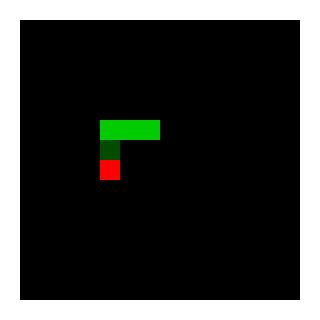

stream interrupted


In [440]:
show_live_env(env, lambda o: env.action_space.sample(), duration=80, fps=20000)

# Utils

In [441]:
# https://github.com/cyoon1729/deep-Q-networks/blob/master/vanillaDQN/dqn.py#L51
def dqn_loss(model, batch):
    criterion = nn.MSELoss()

    obs, actions, rewards, next_obs = batch
    obs = torch.FloatTensor(obs).to(DEVICE)
    actions = torch.LongTensor(actions).to(DEVICE)
    rewards = torch.FloatTensor(rewards).to(DEVICE)
    next_obs = torch.FloatTensor(next_obs).to(DEVICE)

    q_vals = model(obs).index_select(dim=1, index=actions)[0]
    next_q_vals = model(next_obs).max(dim=1)[0]
    target_q_vals = next_q_vals * discount + rewards

    return criterion(q_vals, target_q_vals)

In [539]:
def dense(i, o, a=nn.Sigmoid):
    l = nn.Linear(i, o)
    return nn.Sequential(l, a())

def lam(func):
    class Lambda(nn.Module):
        def forward(self, *args):
            return func(*args)

    return Lambda()

In [543]:
# net = nn.Sequential(
#     lam(lambda x: x.permute(0, 3, 1, 2)),
#     nn.Conv2d(3, 32, kernel_size=2, stride=2),
#     nn.ReLU(),
#     nn.Conv2d(32, 64, kernel_size=3, stride=4),
#     nn.ReLU(),
#     nn.Flatten(),
#     nn.Linear(256, 64),
#     nn.ReLU(),
#     nn.Linear(64, 4),
# )

# t = torch.rand(4, 16, 16, 3)
# net(t).shape

# Model

In [530]:
obs_size = 16 * 16 * 3
num_actions = 4
hidden_dim = 512
discount = 0.999

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()

        self.net = nn.Sequential(
            lam(lambda x: x.permute(0, 3, 1, 2)),
            nn.Conv2d(3, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=4),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 4),
        ).to(DEVICE)

        self.optimizer = torch.optim.Adam(params=self.parameters(), lr=0.001)

    def forward(self, obs):
        return self.net(obs)
        
    def get_max_action(self, obs):
        obs = obs[np.newaxis, ...] / 255
        obs = torch.FloatTensor(obs).to(DEVICE)
        q_vals = self.net(obs)[0]

        return q_vals.argmax().cpu().detach().numpy()


dqn = DQN()

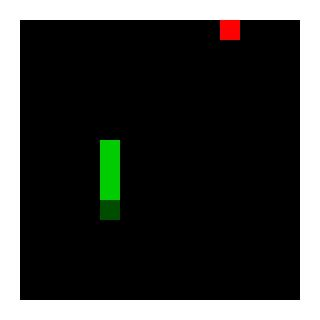

In [531]:
def dqn_controller(obs):
    return dqn.get_max_action(obs)

show_live_env(env, dqn_controller, duration=80, fps=200)

# Experience provider

In [532]:
from collections import deque

def get_experience_generator(env, model, bs, greediness):
    max_rollout_steps = 1000
    buffer_size = 100_000
    ee_tradeoff = 0.5

    episode_rewards = []
    experience_pool = deque(maxlen=buffer_size)

    while True:
        obs = env.reset()
        done = False
        step = 0
        episode_rewards.append(0)

        while not done and step < max_rollout_steps:
            step += 1

            use_model = random.random() < greediness
            if use_model:
                action = model.get_max_action(obs)
            else:
                action = env.action_space.sample()

            next_obs, reward, done, _info = env.step(action)
            experience_pool.append((obs / 255, action, reward, next_obs / 255))

            obs = next_obs
            episode_rewards[-1] += reward

            if len(experience_pool) >= bs:
                batch = random.sample(experience_pool, bs)
                yield [np.array(t) for t in zip(*batch)], episode_rewards


generator = get_experience_generator(env, dqn, bs=100, greediness=0)
batch, episode_rewards = next(generator)
[t.shape for t in batch], episode_rewards

([(100, 16, 16, 3), (100,), (100,), (100, 16, 16, 3)],
 [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0])

# Training

In [533]:
def dqn_optimize(env, model, its, next_batch):
    tr = trange(its, bar_format='{bar} {desc}')

    for i in tr:
        batch, episode_rewards = next(next_batch)

        model.optimizer.zero_grad()
        loss = dqn_loss(model, batch)
        loss.backward()
        model.optimizer.step()

        description = [
            'it %i/%i' % (i + 1, its),
            'loss: %.6f' % loss.item(),
            'moving avg episodes: %.2f' % np.mean(episode_rewards[-100:])
        ]

        tr.set_description(' | '.join(description))

In [534]:
dqn_optimize(
    env=env,
    model=dqn,
    its=3000,
    next_batch=get_experience_generator(
        env,
        dqn,
        bs=128,
        greediness=0.2,
    ),
)

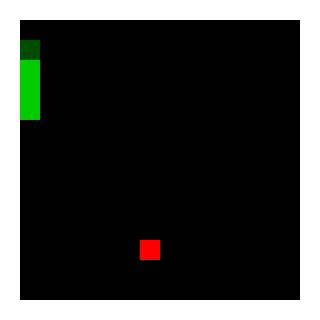

stream interrupted


In [544]:
show_live_env(env, dqn_controller, duration=800, fps=80)